In [1]:
import numpy as np
import scipy.sparse as sp
from problems import Problem_sparse
from bounds.primary.truth import truth
from problems import solve
import seaborn as sns

In [24]:
from mip import Model

mps = Model()
PROBLEM_NAME = "fit2d"
mps.read(f"/Users/gderval/Downloads/{PROBLEM_NAME}.mps")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-15
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-15
Read MPS format model from file /Users/gderval/Downloads/fit2d.mps
Reading time = 0.02 seconds
FIT2D: 25 rows, 10500 columns, 129018 nonzeros


In [25]:
mps.sense

'MIN'

In [26]:
a_eq = []
b_eq = []
a_ineq = []
b_ineq = []

for ctr in mps.constrs:
    mul = -1 if ctr.expr.sense == ">" else 1
    if ctr.expr.sense == "=":
        a = a_eq
        b = b_eq
    else:
        a = a_ineq
        b = b_ineq
    ctr_idx = len(b)
    
    for var, val in ctr.expr.expr.items():
        a.append((ctr_idx, var.idx, val*mul))
    b.append(mul*ctr.rhs)

In [27]:
for v in mps.vars:
    if v.ub < 1e20:
        a_ineq.append((len(b_ineq), v.idx, 1.0))
        b_ineq.append(v.ub)
    if v.lb > -1e20:
        a_ineq.append((len(b_ineq), v.idx, -1.0))
        b_ineq.append(-v.lb)

In [28]:
c = np.zeros((1, len(mps.vars)))
for var, val in mps.objective.expr.items():
    c[0,var.idx] = val

In [29]:
csr_a_eq = sp.coo_array(([x[2] for x in a_eq], ([x[0] for x in a_eq], [x[1] for x in a_eq])), shape=(len(b_eq), len(mps.vars))).tocsr()
csr_a_ineq = sp.coo_array(([x[2] for x in a_ineq], ([x[0] for x in a_ineq], [x[1] for x in a_ineq])), shape=(len(b_ineq), len(mps.vars))).tocsr()

In [30]:
orig_a_eq = csr_a_eq
orig_a_ineq = csr_a_ineq
orig_b_eq = np.array(b_eq).reshape((-1, 1))
orig_b_ineq = np.array(b_ineq).reshape((-1, 1))
orig_c = c

## Random perturbations

In [31]:
random = np.random.default_rng(12280752884384100672342137672332424406)
n_perturbated_ctrs = 100
min_perturbation_ratio = 0.3
max_perturbation_ratio = 0.9

# first randomly select len(mps.ctrs)*ratio_ctrs constraints
n_ctrs = csr_a_eq.shape[0] + csr_a_ineq.shape[0]



In [32]:
FOUND_VALUES = []

In [33]:


while True:
    print("START RUN", "CURRENT BEST", 0 if not FOUND_VALUES else FOUND_VALUES[-1][0])
    perturbated_cstrs = random.choice(n_ctrs, size=n_perturbated_ctrs, replace=False)
    perturbated_cstrs_eq = [x for x in perturbated_cstrs if x < csr_a_eq.shape[0]]
    perturbated_cstrs_ineq = [x-csr_a_eq.shape[0] for x in perturbated_cstrs if x >= csr_a_eq.shape[0]]
    
    #perturbated_cstrs_eq = []
    #perturbated_cstrs_ineq = random.choice(csr_a_ineq.shape[0], size=n_perturbated_ctrs, replace=False)
    def separate(csr_array, perturbated_idx):
        perturbated_idx_set = set(perturbated_idx)
        not_perturbated_idx = [x for x in range(csr_array.shape[0]) if x not in perturbated_idx_set]
        return csr_array[not_perturbated_idx, :], csr_array[perturbated_idx, :]
    
    a1_eq, a2_eq = separate(orig_a_eq, perturbated_cstrs_eq)
    b1_eq, b2_eq = separate(orig_b_eq, perturbated_cstrs_eq)
    a1_ineq, a2_ineq = separate(orig_a_ineq, perturbated_cstrs_ineq)
    b1_ineq, b2_ineq = separate(orig_b_ineq, perturbated_cstrs_ineq)

    def compute_perturbation(csr_array, nb_perturbated_per_row=3):
        data = np.zeros_like(csr_array.data)
        for row in range(csr_array.shape[0]):
            nb = csr_array.indptr[row+1] - csr_array.indptr[row]
            perturbated = random.choice(nb, size=min(nb, nb_perturbated_per_row)) + csr_array.indptr[row]
            data[perturbated] = csr_array.data[perturbated] * random.uniform(min_perturbation_ratio, max_perturbation_ratio, size=min(nb, nb_perturbated_per_row)) * random.choice([-1, 1], size=min(nb, nb_perturbated_per_row))
        return sp.csr_array((data, csr_array.indices.copy(), csr_array.indptr.copy()), shape=csr_array.shape)
    
    d_eq = compute_perturbation(a2_eq)
    d_ineq = compute_perturbation(a2_ineq)
    
    problem = Problem_sparse(
                    a_1_eq=a1_eq,
                    b_1_eq=b1_eq,
                    a_1_ineq=a1_ineq,
                    b_1_ineq=b1_ineq,
                    a_2_eq=a2_eq,
                    b_2_eq=b2_eq,
                    d_eq=d_eq,
                    a_2_ineq=a2_ineq,
                    b_2_ineq=b2_ineq,
                    d_ineq=d_ineq,
                    c=c.transpose(),
                    minimize=True,
                    range=(-1, 1))
    
    out = solve(problem, -1)
    if np.isnan(out):
        print("SKIP", out)
        continue
    out2 = solve(problem, 0)
    if np.isnan(out2):
        print("SKIP", out, out2)
        continue
    if np.abs(out-out2) < 1:
        print("SKIP", out, out2)
        continue
    out3 = solve(problem, 1)
    if np.isnan(out3):
        print("SKIP", out, out2, out3)
        continue
    if np.abs(out3-out2) < 1:
        print("SKIP", out, out2, out3)
        continue
    if out <= out2 <= out3 or out3 <= out2 <= out:
        print("SKIP", out, out2, out3)
        continue
    if np.abs(out-out3) > 1 and (len(FOUND_VALUES) == 0 or FOUND_VALUES[-1][0] < np.abs(out-out3)):
        FOUND_VALUES.append((
            np.abs(out-out3),
            problem
        ))
        print("FOUND BETTER", np.abs(out-out3), out, out2, out3)

START RUN CURRENT BEST 0
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM_Threads                                 5
CPXPARAM_TimeLimit                               5400
CPXPARAM_Barrier_ConvergeTol                     0.0001
Parallel mode: deterministic, using up to 5 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 4 threads...
Tried aggregator 1 time.
LP Presolve eliminated 21000 rows and 137 columns.
Reduced LP has 25 rows, 10363 columns, and 127760 nonzeros.
Presolve time = 0.04 sec. (42.57 ticks)

Iteration log . . .
Sifting iteration    1 [ 1001]:   Objective     =             0.000000
Sifting iteration    2 [ 2001]:   Objective     =        -31053.919632

Barrier solved model.
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                 

Advanced basis not built.


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM_Threads                                 5
CPXPARAM_TimeLimit                               5400
CPXPARAM_Barrier_ConvergeTol                     0.0001
Parallel mode: deterministic, using up to 5 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 4 threads...
Tried aggregator 1 time.
LP Presolve eliminated 21000 rows and 137 columns.
Reduced LP has 25 rows, 10363 columns, and 127760 nonzeros.
Presolve time = 0.04 sec. (42.57 ticks)

Iteration log . . .
Sifting iteration    1 [ 1001]:   Objective     =             0.000000
Sifting iteration    2 [ 2001]:   Objective     =        -31043.437230

Barrier solved model.
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM

CPLEX Error  1217: No solution exists.
Exception ignored in: <function ZipFile.__del__ at 0x105d4ac20>
Traceback (most recent call last):
  File "/Users/gderval/miniconda3/envs/work/lib/python3.10/zipfile.py", line 1817, in __del__
    def __del__(self):
KeyboardInterrupt: 

KeyboardInterrupt



Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM_Threads                                 5
CPXPARAM_TimeLimit                               5400
CPXPARAM_Barrier_ConvergeTol                     0.0001
Parallel mode: deterministic, using up to 5 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 4 threads...
Tried aggregator 1 time.
LP Presolve eliminated 21000 rows and 137 columns.
Reduced LP has 25 rows, 10363 columns, and 127760 nonzeros.
Presolve time = 0.04 sec. (42.57 ticks)

Iteration log . . .
Sifting iteration    1 [ 1001]:   Objective     =             0.000000
Sifting iteration    2 [ 2001]:   Objective     =        -31081.272628

Barrier solved model.
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM

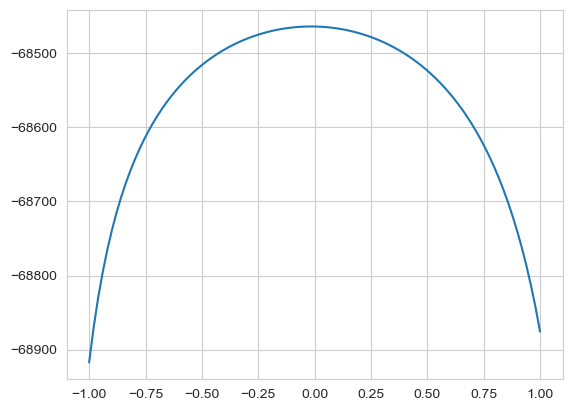

In [34]:
import time

best_problem = FOUND_VALUES[-1][1]
space = np.linspace(-1, 1, 100)
start_time = time.time()
out = truth(best_problem, [-1, 1])["bounds"][0]["bound"](space)
end_time = time.time()
sns.lineplot(x=space,y=out)
print(end_time-start_time)

In [35]:
out

array([-68917.26006483, -68869.51455911, -68829.3461485 , -68794.93415146,
       -68765.04308624, -68738.83268504, -68715.62422394, -68694.91042138,
       -68676.28959811, -68659.45235942, -68644.14597605, -68630.16847784,
       -68617.3479145 , -68605.54628047, -68594.64938515, -68584.5658071 ,
       -68575.21470736, -68566.52624078, -68558.43974575, -68550.89935031,
       -68543.86220679, -68537.28888726, -68531.14442013, -68525.3978893 ,
       -68520.02186682, -68514.99086572, -68510.28427824, -68505.88319545,
       -68501.76603383, -68497.91898098, -68494.32931109, -68490.98613234,
       -68487.87803969, -68484.99312728, -68482.32174724, -68479.85760858,
       -68477.59301294, -68475.52158201, -68473.63756299, -68471.93636981,
       -68470.41402345, -68469.06640904, -68467.89007718, -68466.8817275 ,
       -68466.03915783, -68465.36015428, -68464.84305539, -68464.48635909,
       -68464.28956853, -68464.25221829, -68464.37423017, -68464.65590503,
       -68465.09791594, -

In [36]:
from bounds.primary.lagrangian import bound_lagrangian_flat

lf = bound_lagrangian_flat(best_problem, [-1, 1])
lf

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM_Threads                                 5
CPXPARAM_TimeLimit                               5400
CPXPARAM_Barrier_ConvergeTol                     0.0001
Parallel mode: deterministic, using up to 5 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 4 threads...
Tried aggregator 1 time.
LP Presolve eliminated 21000 rows and 137 columns.
Reduced LP has 25 rows, 10363 columns, and 127760 nonzeros.
Presolve time = 0.04 sec. (42.57 ticks)

Iteration log . . .
Sifting iteration    1 [ 1001]:   Objective     =             0.000000
Sifting iteration    2 [ 2001]:   Objective     =        -31081.272628

Barrier solved model.
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM

{'timing': 3.2752199172973633,
 'bounds': [{'bound': Error(), 'timing': 2.41448712348938}]}

In [37]:
from bounds.primary.lagrangian import bound_lagrangian_quadratic

lf = bound_lagrangian_quadratic(best_problem, [-1, 1])
lf

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM_Threads                                 5
CPXPARAM_TimeLimit                               5400
CPXPARAM_Barrier_ConvergeTol                     0.0001
Parallel mode: deterministic, using up to 5 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 4 threads...
Tried aggregator 1 time.
LP Presolve eliminated 21000 rows and 137 columns.
Reduced LP has 25 rows, 10363 columns, and 127760 nonzeros.
Presolve time = 0.04 sec. (42.57 ticks)

Iteration log . . .
Sifting iteration    1 [ 1001]:   Objective     =             0.000000
Sifting iteration    2 [ 2001]:   Objective     =        -31081.272628

Barrier solved model.
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM

CPLEX Error  1217: No solution exists.


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM_Threads                                 5
CPXPARAM_TimeLimit                               5400
CPXPARAM_Barrier_ConvergeTol                     0.0001
Parallel mode: deterministic, using up to 5 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 4 threads...
Duplicate columns x3620 and x3621 make problem unbounded.
Presolve time = 0.01 sec. (10.30 ticks)


CPLEX Error  1217: No solution exists.


{'timing': 1.1379971504211426,
 'bounds': [{'bound': Error(), 'timing': 0.016709089279174805},
  {'bound': Error(), 'timing': 0.015263795852661133}]}

In [45]:
from bounds.primary.robust import robust_concave_envelope

robust_concave_envelope(best_problem, [-1, 0, 1])

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_LPMethod                                6
CPXPARAM_Threads                                 5
CPXPARAM_TimeLimit                               5400
CPXPARAM_Barrier_ConvergeTol                     0.0001
Parallel mode: deterministic, using up to 5 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 4 threads...
Tried aggregator 1 time.
LP Presolve eliminated 21006 rows and 0 columns.
Reduced LP has 21144 rows, 21000 columns, and 418742 nonzeros.
Presolve time = 0.12 sec. (100.15 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =       -628875.225432
Perturbation started.
Iteration:   303   Dual objective     =       -614250.225432
Iteration:   652   Dual objective     =       -606409.708918
Iteration:  1057   Dual objective     =       -606409.707233
Iteration:  1471   Dual o

{'timing': 11.061781883239746,
 'bounds': [{'timing': 6.192456960678101,
   'bound': Minimize(objects=[Line(a=array([367.38587886]), b=array([-68222.1475676]), limits=(-1, 0)), Line(a=array([354.53933505]), b=array([-68234.99411141]), limits=(-1, 0)), Line(a=array([330.00433145]), b=array([-68256.55205781]), limits=(-1, 0)), Line(a=array([314.96989766]), b=array([-68269.53876665]), limits=(-1, 0)), Line(a=array([267.83717143]), b=array([-68309.07006187]), limits=(-1, 0)), Line(a=array([261.14749164]), b=array([-68314.58641061]), limits=(-1, 0)), Line(a=array([252.90715467]), b=array([-68320.6753571]), limits=(-1, 0)), Line(a=array([189.45902562]), b=array([-68365.40635527]), limits=(-1, 0)), Line(a=array([180.49048994]), b=array([-68371.37308273]), limits=(-1, 0)), Line(a=array([138.23085478]), b=array([-68398.16410336]), limits=(-1, 0)), Line(a=array([93.16867586]), b=array([-68426.47249823]), limits=(-1, 0)), Line(a=array([90.79566035]), b=array([-68427.90790363]), limits=(-1, 0)), L

In [ ]:
len(mps.vars), len(mps.constrs)

In [100]:
len(FOUND_VALUES)

7

In [68]:
d_ineq

<10x232966 sparse array of type '<class 'numpy.float64'>'
	with 26 stored elements in Compressed Sparse Row format>

In [40]:
problem = FOUND_VALUES[-1][1]
sp.save_npz(f"data_{PROBLEM_NAME}_random/a_1_eq.npz", problem.a_1_eq)
sp.save_npz(f"data_{PROBLEM_NAME}_random/a_2_eq.npz", problem.a_2_eq)
sp.save_npz(f"data_{PROBLEM_NAME}_random/a_1_ineq.npz", problem.a_1_ineq)
sp.save_npz(f"data_{PROBLEM_NAME}_random/a_2_ineq.npz", problem.a_2_ineq)
sp.save_npz(f"data_{PROBLEM_NAME}_random/d_eq.npz", problem.d_eq)
sp.save_npz(f"data_{PROBLEM_NAME}_random/d_ineq.npz", problem.d_ineq)
np.savez(f"data_{PROBLEM_NAME}_random/b_1_eq.npz", problem.b_1_eq)
np.savez(f"data_{PROBLEM_NAME}_random/b_2_eq.npz", problem.b_2_eq)
np.savez(f"data_{PROBLEM_NAME}_random/b_1_ineq.npz", problem.b_1_ineq)
np.savez(f"data_{PROBLEM_NAME}_random/b_2_ineq.npz", problem.b_2_ineq)
np.savez(f"data_{PROBLEM_NAME}_random/c.npz", problem.c.transpose())

In [118]:
problem.dual()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 428032